In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Demand
import Solar
import Price
import Date
import Forecast

In [2]:
'''
NEW no battery
'''

'\nNEW no battery\n'

In [3]:
def predictedcharge(bigdata, daywanted):
    
    slope_intercept = pd.read_csv('Data/regression_values.csv')
    
    date = Date.getdatewanted(daywanted, 2014)
    month = Date.getmonth(date)

    slope = slope_intercept['slope'][month-1]
    intercept = slope_intercept['intercept'][month-1]

    cloud = Forecast.getcloudcover(daywanted)

    predicted_insolance = slope*cloud+intercept
    
    predictedcharge = predicted_insolance*1600*0.9
    
    daydemand = []
    for n in range(24):
        if bigdata['Total Supply (kWh)'][n] > 0:
            daydemand.append(bigdata['Total Demand (kWh)'][n])
        
    predictedcharge = predictedcharge-np.sum(daydemand)
    
    return predictedcharge

In [4]:
def chargeneeded(bigdata):

    eff = 0.9
    chargeneeded = 0
    median = np.median(bigdata['Grid Buy Price'])
    batterycharge = 0
    

    for n in range(0,24):
            
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            chargeneeded = chargeneeded + bigdata['Net Demand'][n]/(eff)


    return chargeneeded


In [5]:
## method to run the SMART system ##
## if its predicted

def run_SMART(bigdata, daywanted, starting_soc):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 1120
    power = 415
    eff = 0.9
    
    median = np.median(bigdata['Grid Buy Price'])
#     required_battery_charge = chargeneeded(bigdata)
#     predicted_battery_charge = predictedcharge(bigdata, daywanted)
    
#     print(required_battery_charge, predicted_battery_charge)
    
    for n in range(0,24):
        
        if n == 0:
            soc_temp = starting_soc[daywanted-1]
        else:
            soc_temp = soc[n-1]

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        
#         if required_battery_charge > predicted_battery_charge: 
#             if n == 5:
#                 batteryoutput[n] = max(-power, -(1/eff)*(required_battery_charge - predicted_battery_charge))
#                 soc[n] = soc_temp - batteryoutput[n]*eff
#                 continue
                
#         if n == 0:
#             use = True
#         if n == 14:
#             use = False
#         if bigdata['Grid Buy Price'][n] >= median*1.5:
#             use = True
            
        use = True
        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)
            if use == False:
                soc[n] = soc[n-1]
                batteryoutput[n] = 0

        elif bigdata['Net Demand'][n] < 0:     # charge the battery
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp

        
    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - SMART'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - SMART'] = bigdata['Net Demand - SMART']*bigdata['Grid Buy Price']
    bigdata['Running Cost - SMART'] = bigdata['Running Cost - SMART'].clip(lower=0)
    bigdata['Running Profit - SMART'] = -bigdata['Net Demand - SMART']*bigdata['Grid Sell Price']
    bigdata['Running Profit - SMART'] = bigdata['Running Profit - SMART'].clip(lower=0)
    bigdata['soc - SMART'] = soc
    bigdata['battery output - SMART'] = batteryoutput
    
    ## adds the end day soc into the global vector to use for the next day ##
    starting_soc[daywanted] = soc[23]
    ## returns the new bigdata ##
    
    return bigdata


In [6]:
## initialises the daily cost vectors ##
SMART_cost = np.zeros(365)
SMART_profit = np.zeros(365)
_import_ = np.zeros(24*365)
_export_ = np.zeros(24*365)
solar_prediction = pd.read_csv('Data/solarprediction.csv')
# starting_soc = np.zeros(365)
starting_soc = np.zeros(366)


for n in range(0, 365):

    ## loads in the data ##

    daywanted = n+1
    datewanted = Date.getdatewanted(daywanted, 2014)
    totaldemand = Demand.gettotaldemand(daywanted)
    solarsupply = Solar.getsolarsupply(daywanted)
    buyprice = Price.getvariablebuyprice(daywanted)
    sellprice = Price.getvariablesellprice(daywanted)
    bigdata =pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
    bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
    bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
    bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
    bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
    bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

    ## runs the battery for that day ##
    
    bigdata = run_SMART(bigdata, daywanted, starting_soc)

    ## adds the day into the year vector ##

 
    SMART_cost[n] = bigdata['Running Cost'].sum()
    SMART_profit[n] = bigdata['Running Profit'].sum()
    
#     _import_[n] = bigdata['Net Demand - SMART'].clip(lower=0).sum()
#     temp = bigdata['Net Demand - SMART']*(-1)
#     _export_[n] = temp.clip(lower=0).sum()
    
    ## adds the day into the year vector ##

    for q in range(24):
    
        if bigdata['Net Demand'][q] < 0:
            _export_[n*24+q] = bigdata['Net Demand'][q]*-1
            
        if bigdata['Net Demand'][q] > 0:
            _import_[n*24+q] = bigdata['Net Demand'][q]


In [7]:
SMART_cost.sum()

41057.995524555074

In [8]:
SMART_profit.sum()

97135.318555012

In [9]:
SMART_profit.sum()-SMART_cost.sum()

56077.32303045692

In [10]:
_import_.sum()

380495.5466598958

In [11]:
_export_.sum()

1425087.204355417

In [12]:
import1 = pd.read_csv('final_analysis.csv',usecols=[1])
import1 = np.array(import1)

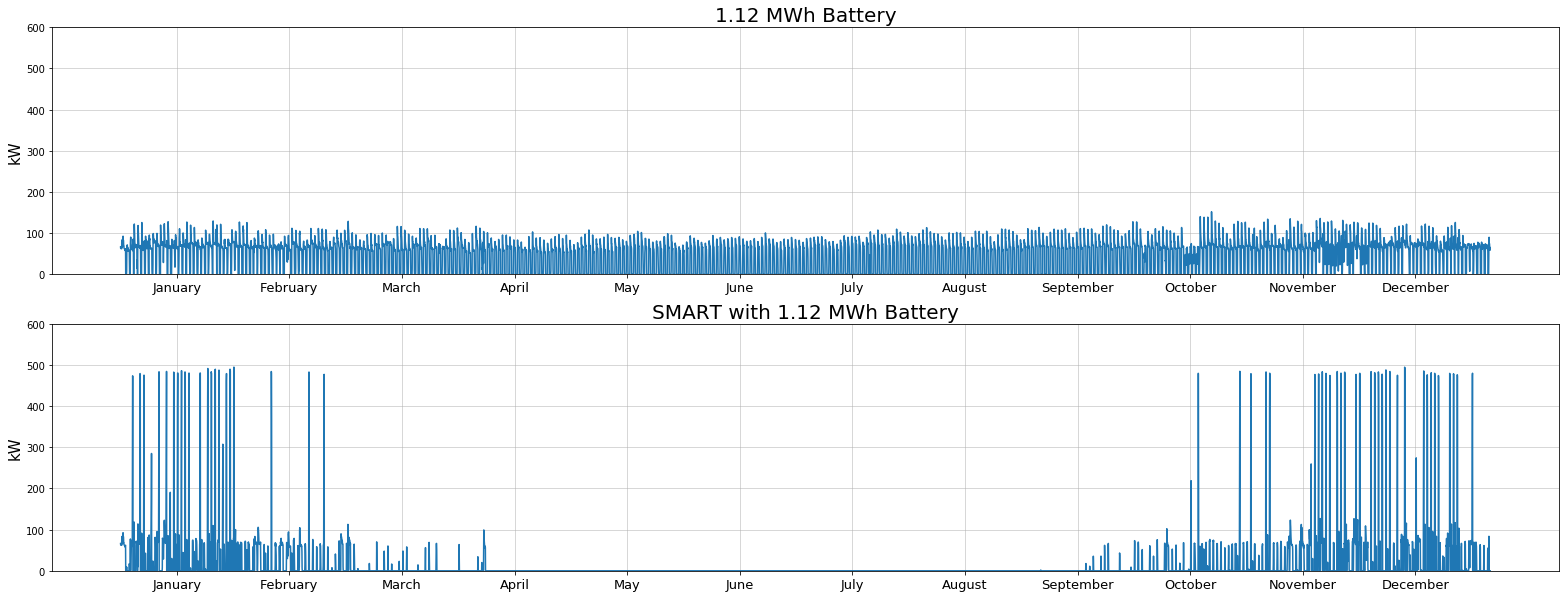

In [13]:
fig, ax = plt.subplots(2, figsize=[27,10])

ax[0].plot(_import_)
ax[0].set_title('1.12 MWh Battery',fontsize=20)
ax[0].set_ylim(0, 600)
ax[0].set_ylabel('kW',fontsize=15)
ax[0].set_xticks([d for d in range(15*24,365*24,30*24)])
ax[0].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'],fontsize=13)
ax[0].grid(lw=0.5)

ax[1].plot(import1)
ax[1].set_title('SMART with 1.12 MWh Battery',fontsize=20)
ax[1].set_ylabel('kW',fontsize=15)
ax[1].set_ylim(0, 600)
ax[1].set_xticks([d for d in range(15*24,365*24,30*24)])
ax[1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'],fontsize=13)
ax[1].grid(lw=0.5)

In [14]:
importing = pd.DataFrame(_import_)
# exporting = pd.DataFrame(_export_)
# exporting.to_csv('Export_vector.csv')
# importing.to_csv('Import_vector.csv')
importing.to_csv('presentation1.csv')

In [15]:
_import_.sum()

380495.5466598958

In [16]:
_export_.sum()


1425087.204355417

In [17]:
_export_.sum()-_import_.sum()

1044591.6576955213

In [18]:
import1[0:20]

array([[66.15667099],
       [62.4997912 ],
       [64.15507469],
       [66.44880568],
       [65.25832813],
       [63.35546281],
       [63.44346318],
       [61.90629786],
       [83.16224156],
       [77.90265177],
       [69.65071115],
       [65.86532302],
       [70.47263656],
       [76.86754714],
       [87.53100984],
       [88.83483026],
       [92.48479984],
       [80.34514687],
       [83.20956469],
       [80.08216172]])